Here, we preprocess the [immune dictionary](https://doi.org/10.1038/s41586-023-06816-9) dataset as described in scPerturb in anticipation that datasets from scPerturb will also be used. rds files are downloaded from the Immune Dictionary [download](https://www.immune-dictionary.org/app/home) page.

In [1]:
import os

import scanpy as sc
import anndata as ad

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import normalized_mutual_info_score as nmi

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', module='pandas')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='ipykernel')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='scanpy')
warnings.filterwarnings(action='ignore', category=UserWarning, module='scanpy')

import sys
sclembas_path = '/home/hmbaghda/Projects/scLEMBAS/scLEMBAS'
sys.path.insert(1, os.path.join(sclembas_path))
from preprocess import get_tf_activity, project_tf_activity

In [2]:
n_cores = 12
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

seed = 888
data_path = '/nobackup/users/hmbaghda/scLEMBAS/analysis'

In [3]:
quick_run = False # whether to subsample data and use quicker/less mem intensive (less accurate) versions of parameters

quick_dict = {'quick': {'perm': int(10), 'n_samples': int(1e3), 'batch_size': int(1e3)},
             'full': {'perm': int(1e3), 'n_samples': None, 'batch_size': int(1e4)}}
if quick_run: 
    run_key = 'quick'
else:
    run_key = 'full'

In [4]:
# grid search params
use_raw = False
# impute = True

In [5]:
directory_names = [
    #data_path,
    #os.path.join(data_path, 'raw'), os.path.join(data_path, 'raw', 'immune_dictionary'),
    os.path.join(data_path, 'interim'), os.path.join(data_path, 'interim', 'immune_dictionary_h5ad'),
    os.path.join(data_path, 'processed'), os.path.join(data_path, 'figures')
]

for directory_name in directory_names:
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)


# Load Files

In [6]:
# h5ad_in_path = os.path.join(data_path, 'interim', 'immune_dictionary_h5ad')
# file_names = os.listdir(h5ad_in_path)

# imm_d = {}
# for file_name in file_names:
#     cell_type = file_name.split('ref_data_')[1].split('.h5ad')[0]
#     adata = sc.read_h5ad(os.path.join(h5ad_in_path, file_name)) # Seurat counts slot in adata.raw.X, data slot in adata.X
#     imm_d[cell_type] = adata
# adata = ad.concat(list(imm_d.values()),  join="outer")

# sco = sorted(adata.obs.seurat_clusters.unique())
# adata.obs.seurat_clusters = pd.Categorical(adata.obs.seurat_clusters,
#                                            categories=sco,
#                                            ordered=True)

# adata.write_h5ad(os.path.join(data_path, 'interim', 'id_all.h5ad'))
adata = sc.read_h5ad(os.path.join(data_path, 'interim', 'id_all.h5ad'))

In [7]:
adata

AnnData object with n_obs × n_vars = 96034 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'
    uns: 'celltype_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_tsne', 'consensus_estimate', 'consensus_pvals'

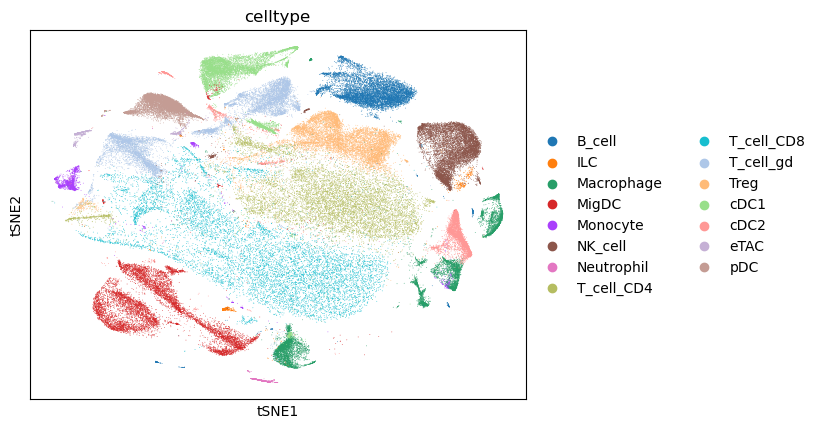

In [8]:
sc.pl.tsne(adata, color='celltype')

<font color='red'>Will probably want to re-process the data from raw fastqs or atleast from raw UMI counts at some point</font>

# Get TF activity estimates:

In [9]:
# if quick_run:
#     adata = sc.pp.subsample(adata, n_obs = quick_dict[run_key]['n_samples'], copy = True, random_state = seed) 

# kwargs = {'args' : {'wsum' : {'times': quick_dict[run_key]['perm'], 'batch_size': quick_dict[run_key]['batch_size']},
#                        'ulm' : {'batch_size': quick_dict[run_key]['batch_size']}, 
#                         'mlm': {'batch_size': quick_dict[run_key]['batch_size']}
#                        }}
# # kwargs['methods'] = ['lm', 'ulm', 'wsum', 
# # kwargs['cns_metds'] = ['lm', 'ulm', 'wsum_norm']
# get_tf_activity(adata, organism = 'mouse', grn = 'collectri', verbose = True, 
#                 min_n = 5, use_raw = use_raw, filter_pvals = False, pval_thresh = 0.05, **kwargs)


# # save
# fn = 'ID_TF_activity_estimate_' + run_key + '.csv'
# fn = os.path.join(data_path, 'interim', fn) 
# adata.obsm['consensus_estimate'].to_csv(fn)
# adata.obsm['consensus_pvals'].to_csv(fn.replace('_estimate_', '_pvals_'))

fn = 'ID_TF_activity_estimate_' + run_key + '.csv'
fn = os.path.join(data_path, 'interim', fn) 
adata.obsm['consensus_estimate'] = pd.read_csv(fn, index_col = 0)
adata.obsm['consensus_pvals'] = pd.read_csv(fn.replace('_estimate_', '_pvals_'), index_col = 0)

Get cell clustering and dimensionality reduction according to TF activity:

In [10]:
tf_adata = project_tf_activity(adata = adata, estimate_key = 'consensus_estimate')
tf_adata.write_h5ad(os.path.join(data_path, 'processed', 'ID_tf_activity.h5ad'))

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


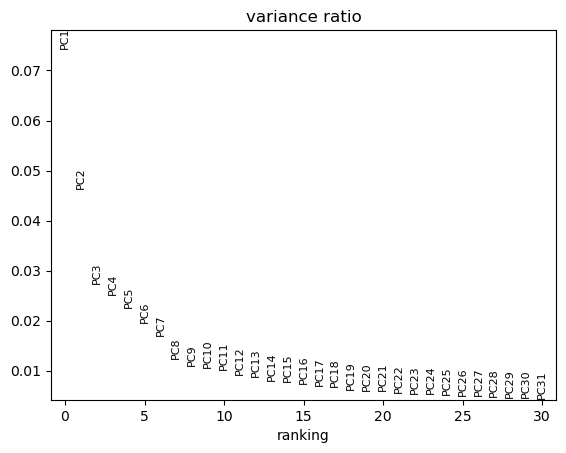

The elbow was automatically identified at PC 8


In [13]:
sc.pl.pca_variance_ratio(tf_adata)
print('The elbow was automatically identified at PC {}'.format(tf_adata.uns['pca']['pca_rank']))

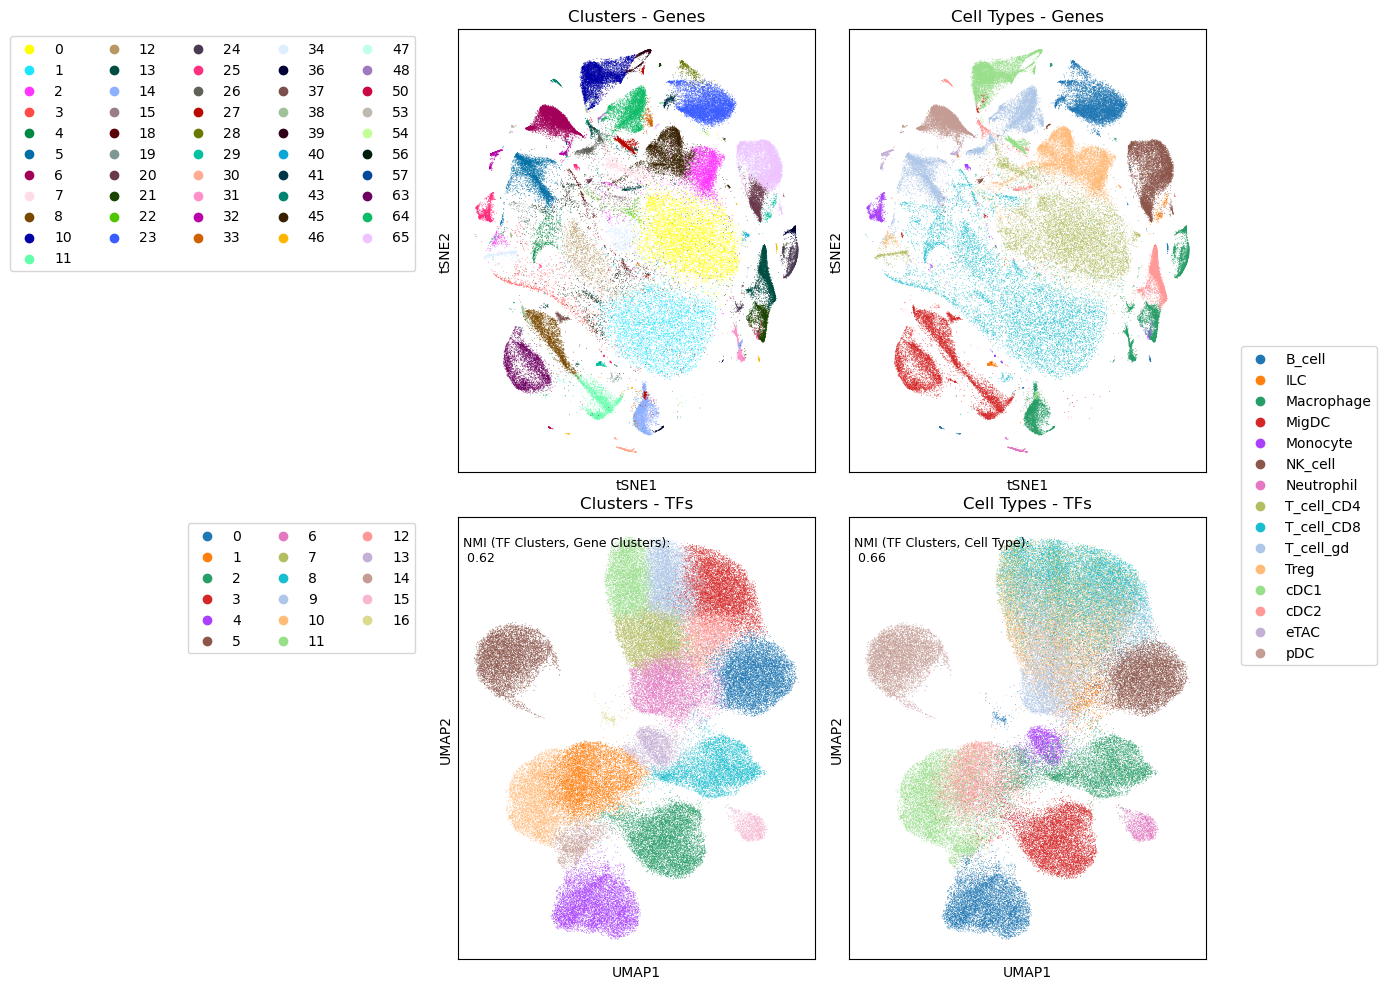

In [12]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))

sc.pl.tsne(adata, color='seurat_clusters', ax = ax[0,0], show = False)
ax[0,0].set_title('Clusters - Genes')
ax[0,0].legend(bbox_to_anchor=(-0.1, 1), ncol = 5, bbox_transform=ax[0,0].transAxes)

sc.pl.tsne(adata, color='celltype', ax = ax[0,1], show = False)
ax[0,1].set_title('Cell Types - Genes')
ax[0, 1].legend(bbox_to_anchor=(1.5, 0.3), bbox_transform=ax[0,1].transAxes)

sc.pl.umap(tf_adata, color='TF_clusters', ax = ax[1,0], show = False)
ax[1,0].set_title('Clusters - TFs')
ax[1,0].legend(bbox_to_anchor=(-0.1, 1), bbox_transform=ax[1,0].transAxes, ncol = 3)
ax[1,0].annotate('NMI (TF Clusters, Gene Clusters):\n {:.2f}'.format(nmi(tf_adata.obs.TF_clusters, tf_adata.obs.seurat_clusters)),
                xy = (0.015, 0.9), xycoords='axes fraction', fontsize = 9)

sc.pl.umap(tf_adata, color='celltype', ax = ax[1,1], show = False)
ax[1,1].set_title('Cell Types - TFs')
ax[1,1].legend().set_visible(False)
ax[1,1].annotate('NMI (TF Clusters, Cell Type):\n {:.2f}'.format(nmi(tf_adata.obs.TF_clusters, tf_adata.obs.celltype)),
                xy = (0.015, 0.9), xycoords='axes fraction', fontsize = 9)

fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()